# Initial analysis

---

Aditya Marathe

**Aims:**
- Load a small sample of the full dataset.
- Learn information about each parameter.
- Check for corelations between different parameters.
- Clean the dataset, which includes:
    - Listwise deletion ([imputation](https://en.wikipedia.org/wiki/Imputation_(statistics))) of NaN or Null records.
    - Does the data makes sense? Remove/Impute data with strange records.
    - Check table data-types and convert them to more appropriate ones if necessary.
    - Dimensionality reduction.
- Basic plots to visualise the data.

## 1. Imports

In [1]:
import os
import sys

import pathlib

In [2]:
%matplotlib inline

import dotenv

import h5py
# import dask
# import dask.dataframe as dd
# import dask.array as da
import pandas as pd

import numpy as np
import numpy.typing as npt

import matplotlib as mpl
import matplotlib.pyplot as plt

**Version and hardware**

In [3]:
print(f'Python {sys.version}\n')
print(f'H5Py {h5py.__version__}')
# print(f'Dask {dask.__version__}')
print(f'Pandas {pd.__version__}')
print(f'NumPy {np.__version__}')
print(f'Matplotlib {mpl.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

H5Py 3.10.0
Pandas 2.1.2
NumPy 1.26.1
Matplotlib 3.8.1


**Local imports**

In [4]:
# Local imports
sys.path.insert(1, './../')

from initial_analysis import *
from cuts import Cuts

**Setting up the enviornment...**

In [5]:
# The '.env' file contains the directory to the data.
dotenv.load_dotenv();

## 2. Getting started

### 2.1 Loading the H5 file

The data is stored in a ~10GB HDF5 which was downloaded from the UCL HEP Linux (CentOS) cluster and stored locally.

H5 files can can structure data hierarchically with parent and child keys. The "really mini" dataset does not have any child keys, but the full dataset (used in '/ref/pidFunSelNotSel.ipynb') does feature parent and child keys. 

The "really mini" dataset contains only relavant data, and some parameters have already been reduced into one. The data contains:
- Mostly $\nu_\mu$ (or $\bar{\nu}_\mu$) events (from hadronic events) since they are common.
- Few $\nu_\text{e}$ (or $\bar{\nu}_\text{e}$) events (from electromagnetic events).
- Very few $\nu_\tau$ (or $\bar{\nu}_\tau$) events.

The first 1,000 events in the "really mini" dataset were used to calculate a correlation matrix for all parameters along with a basic column data summary. This information is stored as HTML files (refer to '/dataset_info/really_mini').

In [6]:
file_dir = pathlib.Path(os.environ['MINI_DATA_DIR'])
n_events = 4_000_000

with h5py.File(file_dir, 'r') as file:
    df = pd.DataFrame(data={key:file[key][:n_events] for key in file.keys()})

In [7]:
df.head()

,3flavourveto,ccAll,cosBeamFirst,isANuECC,isANuMuCC,isCC,isNC,isNotNu,isNuECC,isNuMu,...,rec.sel.cvnloosepreselptp.nutauid,rec.sel.remid.pid,rec.sel.scann.scpid,rec.slc.ncontplanes,rec.slc.nhit,rec.trk.cosmic.ntracks,rec.trk.kalman.ntracks,recoq2,recow,trueEnu
0,False,0,0.114537,False,False,False,False,True,False,False,...,-5.0,0.336538,0.096694,9,41,1,1,0.925479,0.610270,0.000000
1,False,0,0.825868,False,False,False,False,True,False,False,...,-5.0,0.974734,0.191486,93,309,1,1,8.439269,NaN,0.000000
2,True,0,0.580387,False,False,False,False,True,False,False,...,-5.0,0.945310,0.132330,57,318,1,1,3.127142,NaN,0.000000
3,True,1,0.926336,False,False,True,False,False,False,True,...,-5.0,0.936047,0.884369,19,43,1,1,0.099019,1.090893,0.839629
4,False,0,0.041819,False,False,False,False,True,False,False,...,-5.0,0.543133,0.087294,8,47,1,1,1.783101,0.280110,0.000000


### 2.2 Understanding the parameters

**1) MC truth parameters**

- `'pdgAll'`  : Relevant PDG IDs (refer to [this](https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)) could be one of three: 0, $\pm$ 12 ($\nu_\text{e}$ or $\bar{\nu}_\text{e}$), or $\pm$ 14 ($\nu_\mu$ or $\bar{\nu}_\mu$) (int16).
- `'modeAll'`     : Interaction mode (e.g. a QE interaction mode) (int32)

*(i) Flags* (bool)

- `'isANuECC'`    : $\bar{\nu}_\text{e}$ CC events
- `'isANuMuCC'`   : $\bar{\nu}_\mu$ CC events
- `'isCC'`        : Charged current events
- `'isNC'`        : Neutral current events
- `'isNotNu'`     : Non-$\nu$ events
- `'isNuECC'`     : Elastic CC events
- `'isNuMu'`      : Muon-neutrino events
- `'isNuMuCC'`    : Muon-neutrino CC events
- `'ccAll'`       : Flag for all CC events (uint16)
- `'rec.mc.nnu'` : Flag for $\mu$ events according to MC simulation (int16)

*(ii) Energy*

- `'trueEnu'`    : True energy of the $\nu$ in the MC simulation [GeV] (float32)

**2) $\nu_\mu$ Cuts** (bool)

- `'numuQuality'`        : Quality cut.
- `'numuBasicQuality'`   : Basic quality cut.
    - The reconstructed $\nu_\mu$ energy is greater than 0.
    - The number of hits in a slice `'rec.slc.nhit'` must be greater than 20 becasue low hit events are background.
    - There should be at least one track identified by the Cosmic algorithm.
    - The tracks that are really vertical, i.e. they pass through the less than 4 planes in a slice `'rec.slc.ncontplanes'`, are removed.
    - At least one of the Kalman algorithm tracks must have a non-zero `'rec.sel.remid.pid'`.
- `'numu2020pid'`        : Muon-neutrino CVN PID cut.
    - The `'rec.sel.remid.pid'` must be greater than 0.3.
    - The CVN $\nu_\mu$ PID score must be above 0.8.
- `'numucontain'`        : Muon-neutrino containment cut.
    - The minimum Kalman algorithm track containment (`'rec.sel.contain.kal[fwd/bak]cell'`) is 6 cells.
    - The minimum Cosmic algorithm track containment (`'rec.sel.contain.cos[fwd/bak]cell'`) is 5 and 7 cells respectively.
    - *Notes*: Some of the other cuts may not be correct.
- `'numucosrej'`         : Cosmic rejection cut.
    - If the PID score for cosmic rejection `'rec.sel.cosrej.numucontpid202fhc'` is greater than 0.45.
- `'3flavourveto'` : (bool) --> *TODO*: Check how this was defined!
- `'numufull'`           : Events that pass all the cuts.
- `'numunotpid'`         : Events that pass all cuts except CVN PID.

**3) Record: Energy**

*(i) LSTM algorithm (Latest algorithms)*

- `'rec.energy.numu.lstmmuon'`       : $\nu_\mu$ energy [GeV] (float32)
- `'rec.energy.numu.lstmnu'`         : $\nu$ energy [GeV] (float32)

*(ii) $\nu_\mu$ energy (Old algorithms)*

- `'rec.energy.numu.E'`              : $\nu_\mu$ candidate energy [GeV] (float32)
- `'rec.energy.numu.calccE'`         : Calorimetric CC energy [GeV] (float32)

*(iii) Hadronic energy*

- `'rec.energy.numu.hadcalE'`        : Total energy of the hadronic tracks [GeV] (Note: Should equal to the sum of `'rec.energy.numu.hadclust.calE'` and `'rec.energy.numu.hadtrkE'`) (float32)
- `'rec.energy.numu.hadclust.calE'`  : Hadronic calorimetric energy [GeV] (float32)
- `'rec.energy.numu.hadtrkE'`        : Hadronic track energy [GeV] (float32)

*(iv) Regression CVN predictions (Old algorithms)*

- `'rec.energy.numu.regcvnhadE'`     : Regression CVN hadronic energy [GeV] (float32)
- `'rec.energy.numu.hadclust.nhit'`  : Number of hadronic hits (uint32)

**4) Record: Selection parameters** 

*(a) Pre-selection CVN*

Particle IDentification (PID) scores used to predict the type of particle interaction. This algorithm was used for making cuts in the past. The PID scores must sum to 1., and scores greater than 1 or less than 0 can be imputed. (float32)

- `'rec.sel.cvnloosepreselptp.cosmicid'` - Cosmogenic events
- `'rec.sel.cvnloosepreselptp.ncid'`     - NC events
- `'rec.sel.cvnloosepreselptp.nueid'`    - $\nu_\text{e}$ events
- `'rec.sel.cvnloosepreselptp.numuid'`   - $\nu_\mu$ events
- `'rec.sel.cvnloosepreselptp.nutauid'`  - $\nu_\tau$ events

*(b) Misc.*

- `'rec.sel.contain.cosbakcell'`: The last cell of the Cosmic algorithm calculated track (int32)
- `'rec.sel.remid.pid'`         : 
- `'rec.sel.scann.scpid'`       : 
- `'cosBeamFirst'`              : cos(Angle $\theta_\text{first}$ off beam axis) of the first track between [0, 1] (float32)

**5) Record: Time slices** (uint32)

- `'rec.slc.ncontplanes'` : Planes that contain the track in the time slice (uint64)
- `'rec.slc.nhit'`        : Number of hits per slice (uint32)

**6) Record: Track data**

- `'rec.trk.cosmic.ntracks'` : Tracks reconstructed using the Cosmic algorithm (uint64)
- `'rec.trk.kalman.ntracks'` : Tracks reconstructed using by Kalman algorithm (uint64)
- `'recoq2'`                 : Reconstructed $Q^2$ [GeV$^2$] of the event (float32)
    - Calculated using
      $$
        Q^2 = 2 E_\mu^2 - p_\mu \text{cos}(\theta_\text{first}) - m_\mu^2
      $$
      where $E_\mu$ is the $\mu$ energy (LSTM algorithm).
- `'recow'`                  : Reconstructed hadronic invariant mass $W_\text{hadronic}$ [GeV$^2$] (float32)
    - Calculated using
      $$
        W_\text{hadronic}^2 = \sqrt{m_p^2 + 2 m_p (E_\nu - E_\mu) - Q^2}
      $$
      where $m_p = 0.938$ GeV (PDG) is the mass of a proton, $E_\nu$ is the $\nu_\mu$ energy (LSTM algorithm).

*Note*: `recow` contains several NaN entries.

**7) (Record:) Momentum** (float32)

- `'pmu'`  : Muon momentum $p_\mu$ [GeV]
    - Calculated using
      $$
        p_\mu = \sqrt{E_\mu^2 - m_\mu^2}
      $$
      where $m_\mu = 105.658\times 10^{-3}$ GeV is the mass of a muon (PDG).
- `'pt'`   : Transverse momentum $p_t$ [GeV]
    - Calculated using 
    $$
        p_t = p_\mu \text{sin}(\theta_\text{first}) = \frac{p_t}{p_\mu} \times p_\mu
    $$
- `'ptp'`  : Transverse momentum to total momentum ratio $p_t / p_\mu$.
    - Calculated using 
      $$
        \frac{p_t}{p_\mu} = \sqrt{1 - \text{cos}^2(\theta_\text{first})} = \text{sin}(\theta_\text{first})
      $$
      We have essentially used the relationship $p_t = p_\mu\text{sin}(\theta_\text{first})$

### 2.3 Preparing the data

In [8]:
# PDG Data
MASS_MUON = 105.658E-3  # GeV
MASS_PROTON = 0.938  # GeV

In [9]:
# TODO
def q_squared(
        muon_energy: npt.ArrayLike,
        muon_momentum: npt.ArrayLike,
        cos_theta_f: npt.ArrayLike,
        muon_mass: float = MASS_MUON
    ) -> npt.ArrayLike:
    ...

In [10]:
# Create a new 'Event' column to store the name of the event e.g. 'Muon'
df['Event'] = get_event_from_pid_score(df)
df['Event'].head()

0    Cosmic
1    Cosmic
2    Cosmic
3      NuMu
4    Cosmic
Name: Event, dtype: object

In [11]:
# Remove some of the columns we don't need
df.drop(columns=[
    'rec.trk.cosmic.ntracks',  # --> All values = 1
    'rec.sel.cvnloosepreselptp.nutauid'  # --> All values = -5
]);

In [12]:
# TODO: Rename columns
# col_rename_map = {
#     ...
# }
# df.rename(columns=col_rename_map, inplace=True)

## 3. Playing with the data


In [13]:
def signal_cut(df: pd.DataFrame) -> pd.Series:
    return df['isNuMuCC']

In [14]:
mc_truth_cuts = Cuts()
mc_truth_cuts.define_cut(name='Signal', cut_func=signal_cut)

In [15]:
# Defining some cuts to extract signal data
numu_cuts = Cuts.init_nova_cuts()

#### 4.1 Neutrino energies

In [16]:
data_numu_passed = numu_cuts.apply_all_cuts(df)

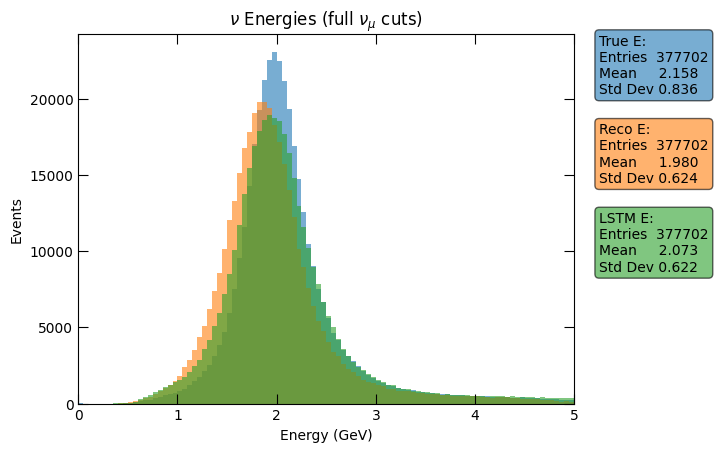

In [17]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 100 + 1)

*_, bc = ax.hist(data_numu_passed['trueEnu'], bins=bins_conf, alpha=0.6)
plot_info(data_numu_passed['trueEnu'], bc, 'True E')

*_, bc = ax.hist(data_numu_passed['rec.energy.numu.E'], bins=bins_conf, alpha=0.6)
plot_info(data_numu_passed['rec.energy.numu.E'], bc, 'Reco E')

*_, bc = ax.hist(data_numu_passed['rec.energy.numu.lstmnu'], bins=bins_conf, alpha=0.6)
plot_info(data_numu_passed['rec.energy.numu.lstmnu'], bc, 'LSTM E')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

ax.set_title(r'$\nu$ Energies (full $\nu_\mu$ cuts)')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


Convoluting the off-axis specturm with the oscillation probability results in a histogram like shown above with peak at 2 GeV.

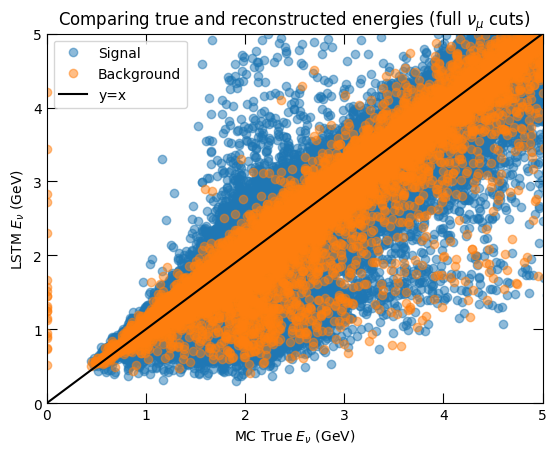

In [18]:
fig, ax = plt.subplots()

ax.plot(
    mc_truth_cuts.apply_cut(name='Signal', df=data_numu_passed)['trueEnu'], 
    mc_truth_cuts.apply_cut(name='Signal', df=data_numu_passed)['rec.energy.numu.lstmnu'], 'o', alpha=0.5, label='Signal'
)
ax.plot(
    mc_truth_cuts.apply_cut(name='Signal', df=data_numu_passed, passed=False)['trueEnu'], 
    mc_truth_cuts.apply_cut(name='Signal', df=data_numu_passed, passed=False)['rec.energy.numu.lstmnu'], 'o', alpha=0.5, label='Background'
)

line_data = np.linspace(
    min(data_numu_passed['trueEnu']), 
    max(data_numu_passed['rec.energy.numu.lstmnu']), 
    2
)

ax.plot(line_data, line_data, 'k', label='y=x')

ax.legend()

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

ax.set_title(r'Comparing true and reconstructed energies (full $\nu_\mu$ cuts)')

ax.set_xlabel(r'MC True $E_\nu$ (GeV)')
ax.set_ylabel(r'LSTM $E_\nu$ (GeV)');


The LSTM algorithm tends to underestimate energy, which is also reflected in the mean.


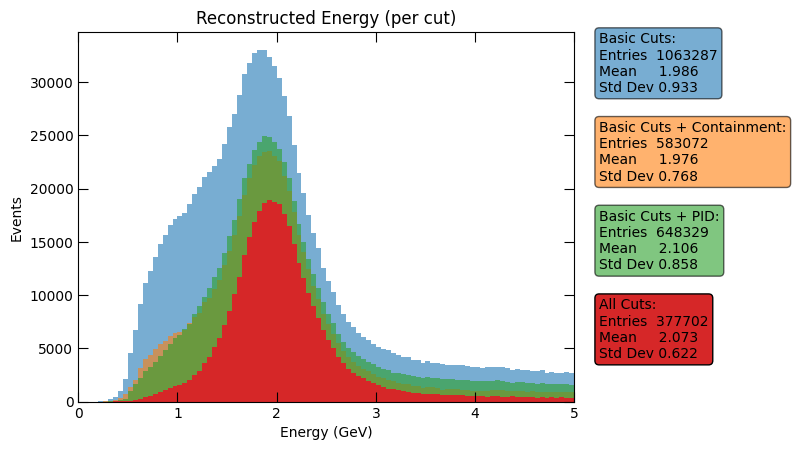

In [19]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 100 + 1)

# Using the newer algorithm
_key = 'rec.energy.numu.lstmnu'

# *_, bc = ax.hist(df[_key], bins=bins_conf, alpha=0.6)
# plot_info(df[_key], bc, r'All events')

data_basic_cuts = numu_cuts.apply_cuts(names=['Detector Quality', 'Data Quality', 'Cosmic Rej.', 'Veto'], df=df)

*_, bc = ax.hist(data_basic_cuts[_key], bins=bins_conf, alpha=0.6)
plot_info(data_basic_cuts[_key], bc, 'Basic Cuts')

data = numu_cuts.apply_cuts(names=['Containment'], df=data_basic_cuts)
*_, bc = ax.hist(data[_key], bins=bins_conf, alpha=0.6)
plot_info(data[_key], bc, 'Basic Cuts + Containment')

data = numu_cuts.apply_cuts(names=['CVN PID Score'], df=data_basic_cuts)
*_, bc = ax.hist(data[_key], bins=bins_conf, alpha=0.6)
plot_info(data[_key], bc, 'Basic Cuts + PID')

data = numu_cuts.apply_all_cuts(df=df)
*_, bc = ax.hist(data[_key], bins=bins_conf)
plot_info(data[_key], bc, 'All Cuts')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlim(0, 5)

ax.set_title(r'Reconstructed Energy (per cut)')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


$$
    \text{Signal-to-background ratio} = \frac{\text{Number of Signal Events}}{\sqrt{\text{Number of Background Events}}}
$$


$$
    \text{Significance} = \frac{\text{Number of Signal Events}}{\sqrt{\text{Number of Signal Events} + \text{Number of Background Events}}}
$$


$$
    \text{Efficiency or Precision} = \frac{\text{Signal Events Post-Cuts}}{\text{Total Signal Events}} = \frac{TP}{TP + TN}
$$


$$
    \text{Energy Resolution} = \sqrt{\text{mean}\left(1 - \frac{\text{Reconstructed Energy}}{\text{True Energy}}\right)}
$$

In [20]:
def significance(n_signal: int, n_background: int) -> float:
    """\
    Calculates the significance.
    """
    return n_signal / np.sqrt(n_signal + n_background)

In [21]:
def sig_back_ratio(n_signal: int, n_background: int) -> float:
    """\
    Calculates the significance.
    """
    return n_signal / np.sqrt(n_background)

In [22]:
# TODO: Implment the efficiency
def efficiency() -> None:
    ...

In [23]:
def energy_resolution(df: pd.DataFrame) -> float:
    """\
    Calculates the energy resolution.
    """
    df = mc_truth_cuts.apply_cut(name='Signal', df=df)
    return np.sqrt(
        np.mean( (1 - (df['rec.energy.numu.lstmnu'] / df['trueEnu']))**2 )
    ) * 100

In [24]:
_cut_names = ['Containment', 'CVN PID Score']

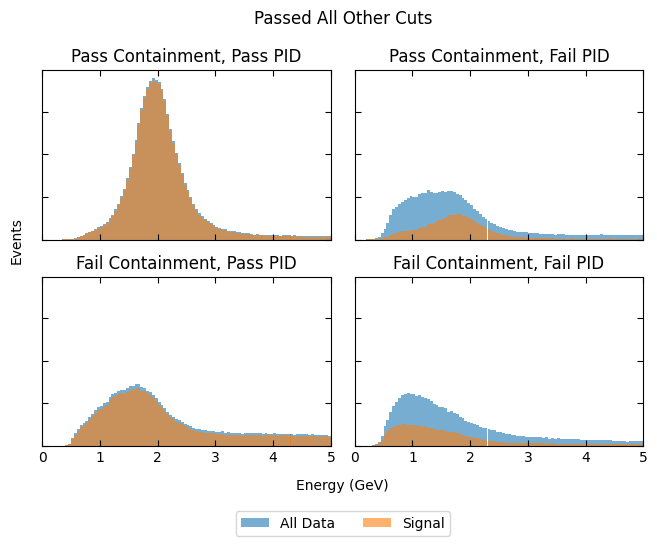

In [68]:
data_cont_pid_dict = {
    'Pass Containment, Pass PID': numu_cuts.apply_cuts(names=_cut_names, df=data_basic_cuts, passed=[True, True]),
    'Pass Containment, Fail PID': numu_cuts.apply_cuts(names=_cut_names, df=data_basic_cuts, passed=[True, False]),
    'Fail Containment, Pass PID': numu_cuts.apply_cuts(names=_cut_names, df=data_basic_cuts, passed=[False, True]),
    'Fail Containment, Fail PID': numu_cuts.apply_cuts(names=_cut_names, df=data_basic_cuts, passed=[False, False])
}

# ==============================================================================

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

axs = axs.flatten()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 100 + 1)

_key = 'rec.energy.numu.lstmnu'

for i, dict_key in enumerate(data_cont_pid_dict):
    *_, bc = axs[i].hist(data_cont_pid_dict[dict_key][_key], bins=bins_conf, alpha=0.6)
    
    # MC Truth
    data = mc_truth_cuts.apply_cut(name='Signal', df=data_cont_pid_dict[dict_key])
    *_, bc = axs[i].hist(data[_key], bins=bins_conf, alpha=0.6)

    axs[i].set_xlim(0, 5)

    axs[i].set_title(dict_key)

    axs[i].tick_params(axis='both', direction='in', top=True, right=True, size=4)

axs[0].set_yticklabels([])
axs[2].set_yticklabels([])

fig.text(0.5, -0.02, 'Energy (GeV)', ha='center')
fig.text(-0.02, 0.5, 'Events', va='center', rotation='vertical')

fig.suptitle('Passed All Other Cuts')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, labels=['All Data', 'Signal'])

plt.tight_layout();

In [26]:
# Ones that fail PID
data_cont_pid_dict['Pass Containment, Fail PID']['Event'].value_counts()

Event
NC        137831
NuMu       40565
NuE        24098
Cosmic      2876
Name: count, dtype: int64

In [27]:
print_event_info(data_cont_pid_dict['Pass Containment, Fail PID'].iloc[0])

== Event Info =============================================
|
|   Flavour                     NuMu
|   Interaction                 Res NC
|
|   Nu Energy                   1.987 GeV
|   Cos(Theta)                  0.936 deg
|
|   Reconstructed:
|
|       Nu Energy               1.043 GeV
|       Q-squared               0.066 GeV
|       Hadronic Inv. Mass      1.408 GeV
|       # of Hadronic Hits      15
|
|   LSTM Predictions:
|
|       Nu Energy               1.005 GeV
|       Muon Energy             0.382 GeV
|
|   Regression CVN Prediction:
|
|       Hadronic Energy         0.651 GeV
|
|   Cuts:
|
|       Quality                 Passed
|       Containment             Passed
|       Pre-selection CVN       ------>  Likely NC ?
|       Cosmic Rejection        Passed
|       Hadronic (NuMu) CNV     Failed
| 



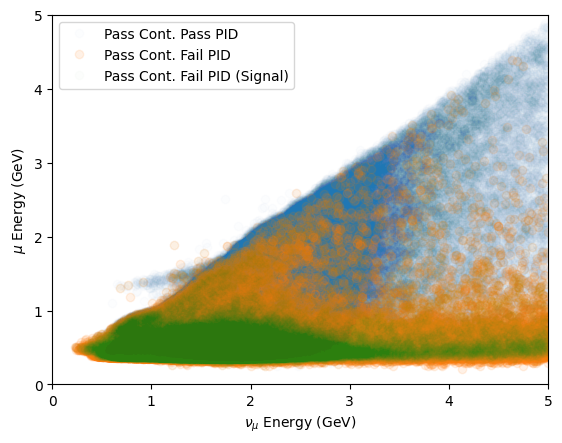

In [56]:
_key = 'rec.energy.numu.lstmmuon'

plt.plot(
    data_cont_pid_dict['Pass Containment, Pass PID']['rec.energy.numu.lstmnu'],
    data_cont_pid_dict['Pass Containment, Pass PID'][_key],
    'o',
    alpha=0.01,
    label='Pass Cont. Pass PID'
)

# """
plt.plot(
    data_cont_pid_dict['Pass Containment, Fail PID']['rec.energy.numu.lstmnu'],
    data_cont_pid_dict['Pass Containment, Fail PID'][_key],
    'o',
    alpha=0.1,
    label='Pass Cont. Fail PID'
)
# """

data = mc_truth_cuts.apply_cut(name='Signal', df=data_cont_pid_dict['Pass Containment, Fail PID'])
# """
plt.plot(
    data['rec.energy.numu.lstmnu'],
    data[_key],
    'o',
    alpha=0.01,
    label='Pass Cont. Fail PID (Signal)'
)
# """

plt.xlabel(r'$\nu_\mu$ Energy (GeV)')
plt.ylabel(r'$\mu$ Energy (GeV)')

plt.xlim(0, 5)
plt.ylim(0, 5)

plt.legend();

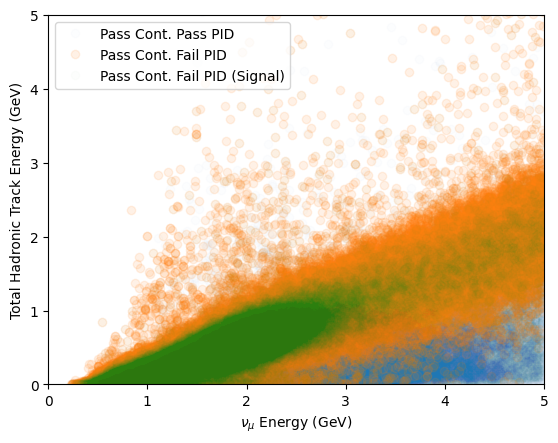

In [62]:
_key = 'rec.energy.numu.hadcalE'

plt.plot(
    data_cont_pid_dict['Pass Containment, Pass PID']['rec.energy.numu.lstmnu'],
    data_cont_pid_dict['Pass Containment, Pass PID'][_key],
    'o',
    alpha=0.01,
    label='Pass Cont. Pass PID'
)

# """
plt.plot(
    data_cont_pid_dict['Pass Containment, Fail PID']['rec.energy.numu.lstmnu'],
    data_cont_pid_dict['Pass Containment, Fail PID'][_key],
    'o',
    alpha=0.1,
    label='Pass Cont. Fail PID'
)
# """

data = mc_truth_cuts.apply_cut(name='Signal', df=data_cont_pid_dict['Pass Containment, Fail PID'])
# """
plt.plot(
    data['rec.energy.numu.lstmnu'],
    data[_key],
    'o',
    alpha=0.01,
    label='Pass Cont. Fail PID (Signal)'
)
# """

plt.xlabel(r'$\nu_\mu$ Energy (GeV)')
plt.ylabel(r'Total Hadronic Track Energy (GeV)')

plt.xlim(0, 5)
plt.ylim(0, 5)

plt.legend();

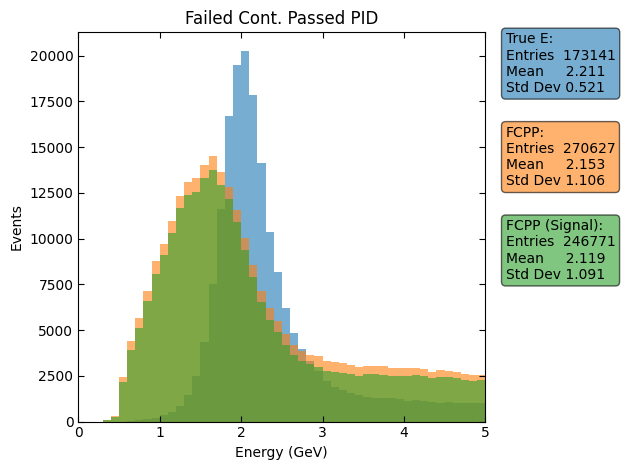

In [82]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 50 + 1)

_key = 'rec.energy.numu.lstmnu'

_ref = data_cont_pid_dict['Fail Containment, Pass PID']['trueEnu']
*_, bc = ax.hist(_ref[_ref > 0], bins=bins_conf, alpha=0.6)
plot_info(_ref[(_ref > 0) & (_ref < 4)], bc, 'True E')

*_, bc = ax.hist(data_cont_pid_dict['Fail Containment, Pass PID'][_key], bins=bins_conf, alpha=0.6)
plot_info(data_cont_pid_dict['Fail Containment, Pass PID'][_key], bc, 'FCPP')

# MC Truth
data = mc_truth_cuts.apply_cut(name='Signal', df=data_cont_pid_dict['Fail Containment, Pass PID'])
*_, bc = ax.hist(data[_key], bins=bins_conf, alpha=0.6)
plot_info(data[_key], bc, 'FCPP (Signal)')

ax.set_xlim(0, 5)

ax.tick_params(axis='both', direction='in', top=True, right=True, size=4)

# ax.set_yticklabels([])
# ax.set_yticklabels([])

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Events')

ax.set_title('Failed Cont. Passed PID')

plt.tight_layout();

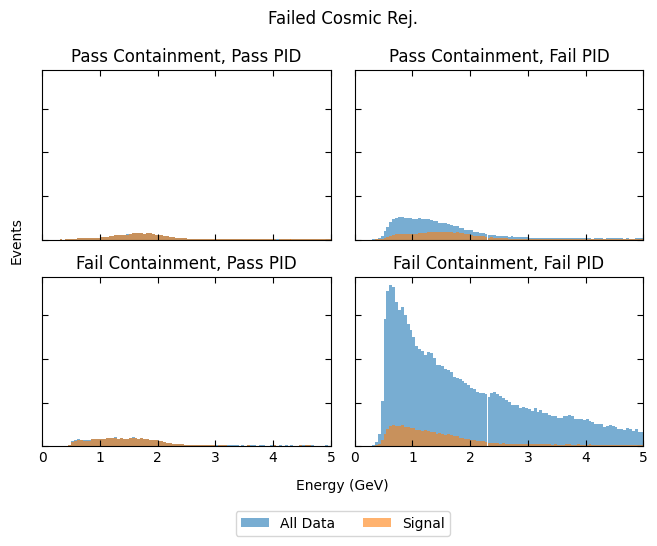

In [28]:
data_cont_pid_dict = {
    'Pass Containment, Pass PID': numu_cuts.apply_all_cuts(df=df, passed=[
        # Detector Quality, Data Quality, CVN PID Score, Containment, Cosmic Rej., Veto
          True,             True,         True,          True,        False,       True
    ]),
    'Pass Containment, Fail PID': numu_cuts.apply_all_cuts(df=df, passed=[
          True,             True,         False,         True,        False,       True
    ]),
    'Fail Containment, Pass PID': numu_cuts.apply_all_cuts(df=df, passed=[
          True,             True,         True,          False,       False,       True
    ]),
    'Fail Containment, Fail PID': numu_cuts.apply_all_cuts(df=df, passed=[
          True,             True,         False,         False,       False,       True
    ])
}

# ==============================================================================

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

axs = axs.flatten()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 100 + 1)

_key = 'rec.energy.numu.lstmnu'

for i, dict_key in enumerate(data_cont_pid_dict):
    *_, bc = axs[i].hist(data_cont_pid_dict[dict_key][_key], bins=bins_conf, alpha=0.6)
    
    # MC Truth
    data = mc_truth_cuts.apply_cut(name='Signal', df=data_cont_pid_dict[dict_key])
    *_, bc = axs[i].hist(data[_key], bins=bins_conf, alpha=0.6)

    axs[i].set_xlim(0, 5)

    axs[i].set_title(dict_key)

    axs[i].tick_params(axis='both', direction='in', top=True, right=True, size=4)

axs[0].set_yticklabels([])
axs[2].set_yticklabels([])

fig.text(0.5, -0.02, 'Energy (GeV)', ha='center')
fig.text(-0.02, 0.5, 'Events', va='center', rotation='vertical')

fig.suptitle('Failed Cosmic Rej.')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, labels=['All Data', 'Signal'])

plt.tight_layout();

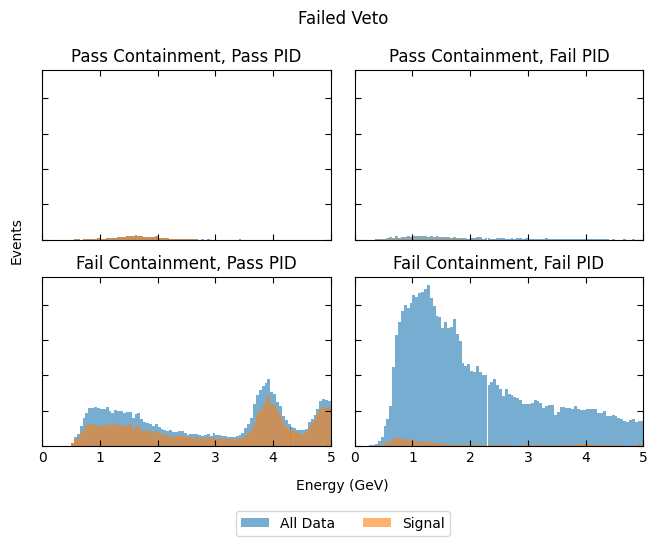

In [29]:
data_cont_pid_dict = {
    'Pass Containment, Pass PID': numu_cuts.apply_all_cuts(df=df, passed=[
        # Detector Quality, Data Quality, CVN PID Score, Containment, Cosmic Rej., Veto
          True,             True,         True,          True,        True,        False
    ]),
    'Pass Containment, Fail PID': numu_cuts.apply_all_cuts(df=df, passed=[
          True,             True,         False,         True,        True,        False
    ]),
    'Fail Containment, Pass PID': numu_cuts.apply_all_cuts(df=df, passed=[
          True,             True,         True,          False,       True,        False
    ]),
    'Fail Containment, Fail PID': numu_cuts.apply_all_cuts(df=df, passed=[
          True,             True,         False,         False,       True,        False
    ])
}

# ==============================================================================

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

axs = axs.flatten()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 100 + 1)

_key = 'rec.energy.numu.lstmnu'

for i, dict_key in enumerate(data_cont_pid_dict):
    *_, bc = axs[i].hist(data_cont_pid_dict[dict_key][_key], bins=bins_conf, alpha=0.6)
    
    # MC Truth
    data = mc_truth_cuts.apply_cut(name='Signal', df=data_cont_pid_dict[dict_key])
    *_, bc = axs[i].hist(data[_key], bins=bins_conf, alpha=0.6)

    axs[i].set_xlim(0, 5)

    axs[i].set_title(dict_key)

    axs[i].tick_params(axis='both', direction='in', top=True, right=True, size=4)

axs[0].set_yticklabels([])
axs[2].set_yticklabels([])

fig.text(0.5, -0.02, 'Energy (GeV)', ha='center')
fig.text(-0.02, 0.5, 'Events', va='center', rotation='vertical')

fig.suptitle('Failed Veto')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, labels=['All Data', 'Signal'])

plt.tight_layout();

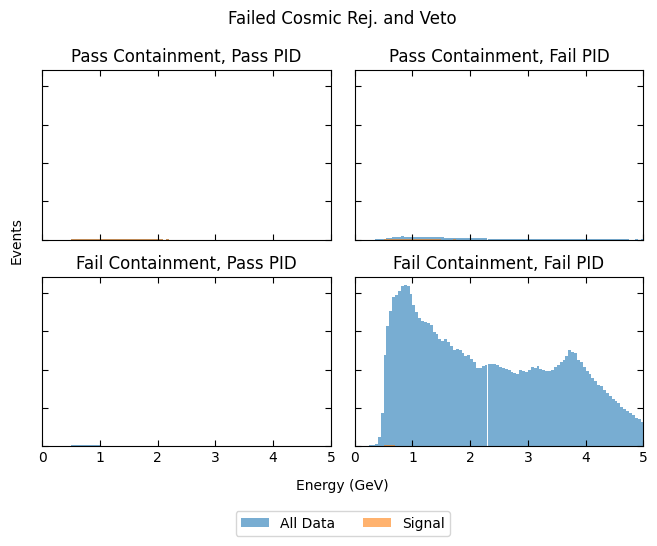

In [30]:
data_cont_pid_dict = {
    'Pass Containment, Pass PID': numu_cuts.apply_all_cuts(df=df, passed=[
        # Detector Quality, Data Quality, CVN PID Score, Containment, Cosmic Rej., Veto
          True,             True,         True,          True,        False,       False
    ]),
    'Pass Containment, Fail PID': numu_cuts.apply_all_cuts(df=df, passed=[
          True,             True,         False,         True,        False,       False
    ]),
    'Fail Containment, Pass PID': numu_cuts.apply_all_cuts(df=df, passed=[
          True,             True,         True,          False,       False,       False
    ]),
    'Fail Containment, Fail PID': numu_cuts.apply_all_cuts(df=df, passed=[
          True,             True,         False,         False,       False,       False
    ])
}

# ==============================================================================

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

axs = axs.flatten()

plot_info = draw_plot_info(ax)

bins_conf = np.linspace(0, 5, 100 + 1)

_key = 'rec.energy.numu.lstmnu'

for i, dict_key in enumerate(data_cont_pid_dict):
    *_, bc = axs[i].hist(data_cont_pid_dict[dict_key][_key], bins=bins_conf, alpha=0.6)
    
    # MC Truth
    data = mc_truth_cuts.apply_cut(name='Signal', df=data_cont_pid_dict[dict_key])
    *_, bc = axs[i].hist(data[_key], bins=bins_conf, alpha=0.6)

    axs[i].set_xlim(0, 5)

    axs[i].set_title(dict_key)

    axs[i].tick_params(axis='both', direction='in', top=True, right=True, size=4)

axs[0].set_yticklabels([])
axs[2].set_yticklabels([])

fig.text(0.5, -0.02, 'Energy (GeV)', ha='center')
fig.text(-0.02, 0.5, 'Events', va='center', rotation='vertical')

fig.suptitle('Failed Cosmic Rej. and Veto')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, labels=['All Data', 'Signal'])

plt.tight_layout();

#### 4.3 Hadronic Energy

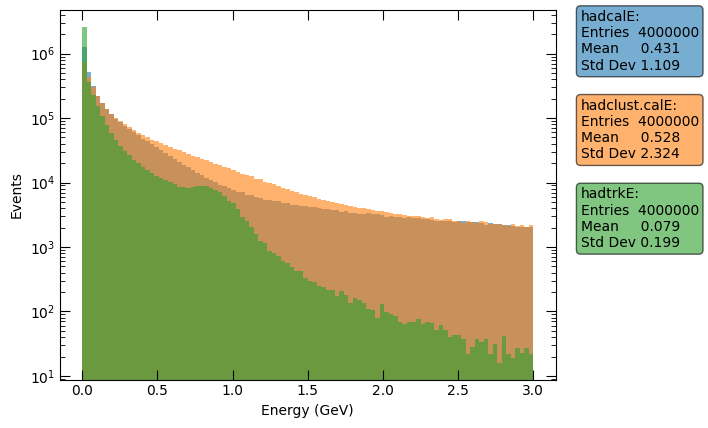

In [31]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)
bins_conf = np.linspace(0, 3, 100 + 1)

*_, bc = ax.hist(df['rec.energy.numu.hadcalE'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.hadcalE'], bc, 'hadcalE')

*_, bc = ax.hist(df['rec.energy.numu.hadclust.calE'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.hadclust.calE'], bc, 'hadclust.calE')

*_, bc = ax.hist(df['rec.energy.numu.hadtrkE'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.hadtrkE'], bc, 'hadtrkE')

ax.set_yscale('log')

ax.tick_params(top=True, right=True)

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


#### 4.4 Quartiles

Calculating the **hadronic energy fraction**.

$$
    E_\text{frac} = \frac{E_\text{had}}{E_\nu}
$$


In [31]:
had_e_func = df['rec.energy.numu.hadclust.calE'] / df['rec.energy.numu.lstmnu']

In [32]:
q1 = had_e_func.quantile(q=0.25)
q2 = had_e_func.quantile(q=0.50)
q3 = had_e_func.quantile(q=0.75)

Energy Resolutions:


C:\Users\Shrey\AppData\Local\Temp\ipykernel_21396\3734737635.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f'{i + 1} {energy_resolution(df=data_numu_passed[had_e_cut]):5.2f}%')


1 13.63%


C:\Users\Shrey\AppData\Local\Temp\ipykernel_21396\3734737635.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f'{i + 1} {energy_resolution(df=data_numu_passed[had_e_cut]):5.2f}%')


2 10.96%


C:\Users\Shrey\AppData\Local\Temp\ipykernel_21396\3734737635.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f'{i + 1} {energy_resolution(df=data_numu_passed[had_e_cut]):5.2f}%')


3 11.78%


C:\Users\Shrey\AppData\Local\Temp\ipykernel_21396\3734737635.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f'{i + 1} {energy_resolution(df=data_numu_passed[had_e_cut]):5.2f}%')


4 13.56%


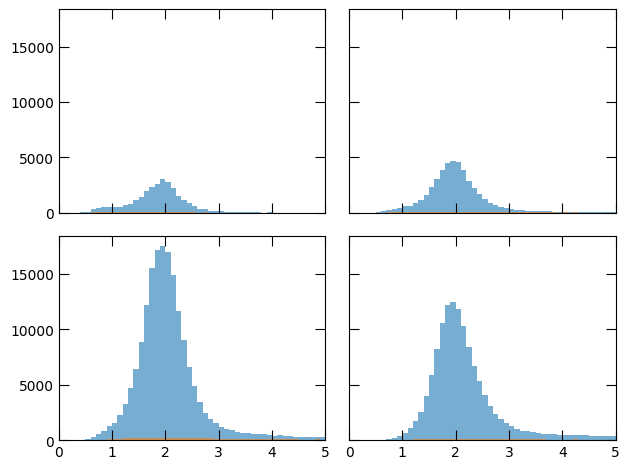

In [33]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

axs = axs.flatten()

bins_conf = np.linspace(0, 5, 50 + 1)

had_e_cuts = [
    (had_e_func <= q1),
    (had_e_func > q1) & (had_e_func <= q2),
    (had_e_func > q2) & (had_e_func <= q3),
    (had_e_func > q3)
]

# had_e_cuts.reverse()

_key = 'rec.energy.numu.lstmnu'

print('Energy Resolutions:')

for i, had_e_cut in enumerate(had_e_cuts):
    axs[i].hist(
        data_numu_passed[_key][had_e_cut], 
        bins=bins_conf, alpha=0.6
    )

    axs[i].hist(
        mc_truth_cuts.apply_cut(name='Signal', df=data_numu_passed, passed=False)[_key][had_e_cut], 
        bins=bins_conf, alpha=0.6
    )
    axs[i].tick_params(axis='both', direction='in', top=True, right=True, size=7)
    axs[i].tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)
    
    print(f'{i + 1} {energy_resolution(df=data_numu_passed[had_e_cut]):5.2f}%')

    axs[i].set_xlim(0, 5)

plt.tight_layout();
